# Práctico 1

Integrantes:

* Finzi, Nadia
* Villafañe, Roxana Noelia

En este práctico, correspondiente a la primera mitad de la materia, trabajaremos con un dataset extraído de Twitter. La idea es emplear los conceptos de grafos vistos en clase sobre un caso real de actualidad.

## Dataset

El dataset consiste en un conjunto de hilos de tweets, con un total de ~150000 tweets, extraídos entre Enero y Marzo de 2021. La temática de los mismos está referida a la vacunación contra el covid-19 en Argentina.

Pueden descargar el dataset del siguiente [link](https://drive.google.com/file/d/1X_qKsE8muAnom2tDX4sLlmBAO0Ikfe_G/view?usp=sharing).

### Campos

- **created_at:** Fecha del tweet
- **id_str:** ID del tweet
- **full_text:** Contenido del tweet
- **in_reply_to_status_id:** ID del tweet inmediatamente anterior en el hilo
- **in_reply_to_user_id:** Autor del tweet inmediatamente anterior en el hilo
- **user.id:** Autor del tweet
- **user_retweeters:** Lista de ID de usuarios que retweetearon el tweet
- **sentiment:** Etiquetado manual que indica el sentimiento o intención del tweet con respecto al tweet anterior en el hilo

In [ ]:
#import pandas as pd
#from pathlib import Path

## Descargar el csv con los datos en este directorio
#DATA_DIR = Path('../data/twitter')
#INPUT_FILE = DATA_DIR / 'vacunas.csv'

## Creamos el directorio en caso de que no exista
#DATA_DIR.mkdir(parents=True, exist_ok=True)

## Configuración inicial

In [ ]:
# seteo de entorno
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#%cd /content/drive/My\ Drive/grafos/

In [ ]:
# Varios
import pandas as pd
import networkx as nx
import igraph #importamos igraph
from igraph import Graph

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pylab


# Clustering
from cdlib import NodeClustering, evaluation, algorithms

# Comunidades
import community.community_louvain
import community
from community import community_louvain
import community as community_louvain

# Drive
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials


In [ ]:
sns.set_context('talk')

In [ ]:
def plot_graph(g, comms, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(12,12))
        
    colors = np.zeros(g.number_of_nodes(), dtype='int')
    for comm, node in enumerate(comms):
        colors[node] = comm

    pos = nx.spring_layout(g, seed=22)
    nx.draw(
        g, with_labels=True, pos=pos, node_color=colors, cmap='Set2', 
        ax=ax
    )
    return ax

def plot_graph_by_parameters(g, comms_dict, parameter_name):
    ncols = len(comms_dict)
    fig, axes = plt.subplots(figsize=(8*ncols, 10), ncols=ncols)
    for i, (param, comms) in enumerate(comms_dict.items()):
        ax = axes[i]
        comms = comms_dict[param]
        Q = evaluation.newman_girvan_modularity(g, comms).score
        ax.set_title(f'{parameter_name}: {param:.3f}\nQ = {Q:.3f}')
        plot_graph(g, comms.communities, ax=ax)
    fig.suptitle(f'Algoritmo de {comms.method_name}', fontsize=28)
    return fig, axes 

def create_contingency_table(comms1, comms2):
    """
    Compute contingency table between partition comms1 and
    partition comms2.
    
    The contingency table is defined by
    
    n_{kk'} = |C_k \cap C'_{k'}|.
    """
    table = np.zeros((len(comms1), len(comms2)))
    for i, c1 in enumerate(comms1):
        for j, c2 in enumerate(comms2):
            table[i,j] = len(set(c1).intersection(c2))
    return table

def get_all_node_properties(g):
    """
    Return a set of all node properties of the graph.
    """
    node_props = set()
    for v in g.nodes():
        node_props = node_props.union(set(g.nodes[v].keys()))
    return node_props

def get_membership(comms):
    """
    Devuelve un vector de N elementos, donde el i-ésimo elemento
    corresponde a la etiqueta de la comunidad correspondiente
    al nodo i.
    """
    if isinstance(comms, NodeClustering):
        comms = comms.communities
    N = sum(len(c) for c in comms)
    membership = np.zeros(N, dtype='int')
    for c, nodes in enumerate(comms):
        membership[nodes] = c
    return membership

def get_comparison_matrix(comms1, comms2):
    """
    Construye la matriz de comparación entre particiones. 
    La matriz de comparación es una matriz de 2x2 cuyos 
    elementos están definidos de la siguiente manera:
    
    M_{11}: # pares de nodos que están en la misma comunidad en 'comms1' y 'comms2'
    M_{00}: # pares de nodos que están en distintas comunidades en 'comms1' y 'comms2'
    M_{10}: # pares de nodos que están en la misma comunidad en 'comms1' pero no en 'comms2' 
    M_{01}: # pares de nodos que están en la misma comunidad en 'comms2' pero no en 'comms1'
    """
    if isinstance(comms1, NodeClustering):
        comms1 = comms1.communities
    if isinstance(comms2, NodeClustering):
        comms2 = comms2.communities
    membership1 = get_membership(comms1)
    membership2 = get_membership(comms2)
    N = len(membership1)
    M = np.zeros((2,2), dtype='int')
    for i in range(N):
        for j in range(i+1, N):
            if membership1[i] == membership1[j]:
                if membership2[i] == membership2[j]:
                    M[1,1] += 1
                else:
                    M[1,0] += 1
            else:
                if membership2[i] == membership2[j]:
                    M[0,1] += 1
                else:
                    M[0,0] += 1
    return M

def rand_index(comms1, comms2):
    if isinstance(comms1, NodeClustering):
        comms1 = comms1.communities
    if isinstance(comms2, NodeClustering):
        comms2 = comms2.communities
    M = get_comparison_matrix(comms1, comms2)
    return (M[0,0] + M[1,1]) / M.sum()

def jaccard_index(comms1, comms2):
    if isinstance(comms1, NodeClustering):
        comms1 = comms1.communities
    if isinstance(comms2, NodeClustering):
        comms2 = comms2.communities
    M = get_comparison_matrix(comms1, comms2)
    return M[0,0] / (M[1,1] + M[1,0] + M[0,1])

def mutual_information(comms1, comms2):
    if isinstance(comms1, NodeClustering):
        comms1 = comms1.communities
    if isinstance(comms2, NodeClustering):
        comms2 = comms2.communities
    table = create_contingency_table(comms1, comms2)
    table = table / table.sum()
    MI = 0
    for k1, comm1 in enumerate(comms1):
        for k2, comm2 in enumerate(comms2):
            if table[k1, k2] == 0:
                continue
            pk1 = table.sum(axis=1)[k1]
            pk2 = table.sum(axis=0)[k2]
            if (pk1 == 0) or (pk2 == 0):
                continue
            MI += table[k1, k2] * np.log2(table[k1, k2] / (pk1*pk2))
    return MI

def run_louvain(g, min_res, max_res, samples=10, logspace=True):
    comms_dict = {}
    if logspace:
        resolutions = np.logspace(np.log10(min_res), np.log10(max_res), samples)
    else:
        resolutions = np.linspace(min_res, max_res, samples)
    for resolution in resolutions:
        comms = algorithms.louvain(
            g, weight='weight', resolution=resolution, randomize=False
        )
        comms_dict[resolution] = comms
    return comms_dict

def plot_louvain(g, min_res, max_res, samples=10, logspace=True):
    comms_dict = run_louvain(g, 0.01, 10, samples=200)
    resolutions = comms_dict.keys()
    Q_values = [evaluation.newman_girvan_modularity(g, comms).score for comms in comms_dict.values()]
    fig, ax = plt.subplots(figsize=(12,5))
    ax.set_ylabel('Q')
    ax.set_xlabel('Resolution')
    ax.set_xscale('log')
    ax.plot(resolutions, Q_values, '-', label='Louvain')
    ax.legend()
    return ax

In [ ]:
dtypes = {
    'id_str': str,
    'full_text': str,
    'in_reply_to_status_id': str,
    'in_reply_to_user_id': str,
    'user.id': str
}

In [ ]:
'''
def connect_to_drive():
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  return GoogleDrive(gauth)

def read_csv_from_drive(drive, id, filename):
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(filename)  
  return pd.read_csv(filename, dtype = dtypes)

drive = connect_to_drive() 

df = read_csv_from_drive(drive, '1ecOBly_KJp5GCDOOE3_Rs8F3L3p_QJRk', 'vacunas.csv').dropna(subset=['user_retweeters'])
'''

"\ndef connect_to_drive():\n  auth.authenticate_user()\n  gauth = GoogleAuth()\n  gauth.credentials = GoogleCredentials.get_application_default()\n  return GoogleDrive(gauth)\n\ndef read_csv_from_drive(drive, id, filename):\n  downloaded = drive.CreateFile({'id':id}) \n  downloaded.GetContentFile(filename)  \n  return pd.read_csv(filename, dtype = dtypes)\n\ndrive = connect_to_drive() \n\ndf = read_csv_from_drive(drive, '1ecOBly_KJp5GCDOOE3_Rs8F3L3p_QJRk', 'vacunas.csv').dropna(subset=['user_retweeters'])\n"

In [ ]:
df=pd.read_csv('vacunas.csv', dtype=dtypes).dropna(subset=['user_retweeters'])
df['user_retweeters'] = df['user_retweeters'].apply(lambda x: [str(elem) for elem in eval(x)])
print(df.shape)
df.head()

(155123, 8)


,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user.id,user_retweeters,sentiment
0,Sat Feb 20 03:09:10 +0000 2021,1362962469749153792,Seguimos esperando el comunicado de @norabar r...,NaN,NaN,2737379453,"[2258074658, 159909978, 105301854, 290671142, ...",NaN
1,Sat Feb 20 03:19:59 +0000 2021,1362965193509265417,@Clon_43 @norabar Nora estaba indignada porque...,1362962469749153792,2737379453,32718111,[],NaN
2,Mon Feb 22 23:55:08 +0000 2021,1364000806740111363,"Bueno, Alberto dijo Salud o Economía. La salud...",NaN,NaN,252168075,"[1238117630696972289, 37232479, 12792246571247...",NaN
3,Tue Feb 23 00:09:14 +0000 2021,1364004354374696963,@spitta1969 Tuit del mes Spitta,1364000806740111363,252168075,1156346340802224128,[],NaN
4,Tue Feb 23 00:00:17 +0000 2021,1364002100364128260,@spitta1969 Estas onfire,1364000806740111363,252168075,153663816,[],NaN


### Observamos algunos ejemplos

In [ ]:
idx = 0
print('Texto:', df.full_text.values[idx])
print('Retweets:', len(df.user_retweeters.values[idx]))

Texto: Seguimos esperando el comunicado de @norabar repudiando la situación respecto del gobierno y el tema vacunas. Seamos pacientes que con esto de la pandemia anda con mucho "laburo".
Retweets: 9


In [ ]:
idx = 376
print('Text:', df.full_text.values[idx])
print('Retweets:', len(df.user_retweeters.values[idx]))

Text: Todo lo que hay que entender sobre la decisión –o no– de poner más vacunas en más brazos (por ejemplo, usar las 1º dosis en muchos y si es necesario retrasar la 2º) está en esta excelente nota de Nora Bär. https://t.co/A0I03DyxgO
Retweets: 48


### Calculamos la cantidad de hilos

In [ ]:
roots = df[df['in_reply_to_user_id'].isna()]
roots.shape

(3174, 8)

# **1. Construcción del grafo**

Construir el grafo de retweets, definido de la siguiente manera:

    Tipo de grafo: Dirigido
    Nodos: ID de los usuarios
    Enlaces: (Usuario A) ---> (Usuario B) si B retweeteó algún tweet de A

Con estos datos, el grafo debería tener alrededor de 40000 nodos y 90000 enlaces.

Considerar la versión no dirigida del grafo y estudiar su conectividad. Si existe una única "componente gigante", realizar el resto de las actividades sobre ella, en lugar de sobre el grafo completo.

Calcular las siguientes métricas globales del grafo:

    Grado medio
    Asortatividad
    Transitividad
    Coeficiente de clustering de Watts-Strogatz


In [ ]:
dff = df[['user.id', 'user_retweeters']]
dff.head()

,user.id,user_retweeters
0,2737379453,"[2258074658, 159909978, 105301854, 290671142, ..."
1,32718111,[]
2,252168075,"[1238117630696972289, 37232479, 12792246571247..."
3,1156346340802224128,[]
4,153663816,[]


In [ ]:
df_final = dff.explode('user_retweeters')
df_final.head()

,user.id,user_retweeters
0,2737379453,2258074658
0,2737379453,159909978
0,2737379453,105301854
0,2737379453,290671142
0,2737379453,208721168


In [ ]:
df_final.shape

(320948, 2)

In [ ]:
#debemos remover los NaNs
df_final = df_final.dropna()
df_final.shape

(187297, 2)

## Grafo dirigido

In [ ]:
DG = nx.from_pandas_edgelist(df_final, "user.id", "user_retweeters")
print(nx.info(DG))

Graph with 39800 nodes and 93404 edges


Este chunk de código es para visualizar el grafo, no correrlo!!!!

In [ ]:
#draw_params = dict(
 #   with_labels=True,               ## Incluye los nombres de los nodos
 #   node_color='C1',                ## Elijo el color 1 de la paleta de colores
 #   edge_color='gray',
 #   width=2,                        ## Espesor de los enlaces
 #   font_size=14,
 #   label='Retweets',
 #   pos=nx.kamada_kawai_layout(DG)   ## Algoritmo para embeber el grafo en el plano
#)

#fig, ax = plt.subplots(figsize=(12,8))
#ax.set_title('Grafo de retweets')
#ax.text(0.7, -0.8, '')
#nx.draw(
    #DG, 
    #ax=ax,
    #**draw_params
#)

## Grafo no dirigido

In [ ]:
edges = pd.DataFrame({"source": df_final['user.id'],
                      "target": df_final['user_retweeters']})

In [ ]:
G = nx.from_pandas_edgelist(edges,
                            source='source', 
                            target='target')

In [ ]:
print(nx.info(G))

Graph with 39800 nodes and 93404 edges


In [ ]:
users_nodes = pd.DataFrame(index=list(G.nodes()))
users_nodes

""
2737379453
2258074658
159909978
105301854
290671142
...
2765081259
339254354
346605471
58065646


Tenemos en total 39800 nodos que en este caso son las fuentes, o quienes tuitean. Quienes los retuitean son 93.404 personas, o lo que en grafos denominamos, edges.

En ambos casos (grafo dirigido y no dirigido), consideramos, grafos no pesados. 

## Métricas generales del grafo
(en este caso consideramos la versión no dirigida del grafo para poder calcular métricas globales)



### Grado medio

In [ ]:
degree = G.degree()

degree_list = []

for (n,d) in degree:
    degree_list.append(d)

av_degree = sum(degree_list) / len(degree_list)

print('El promedio del grado es ' + str(av_degree))

El promedio del grado es 4.693668341708543


Text(0.5, 1.0, 'Grados de los nodos')

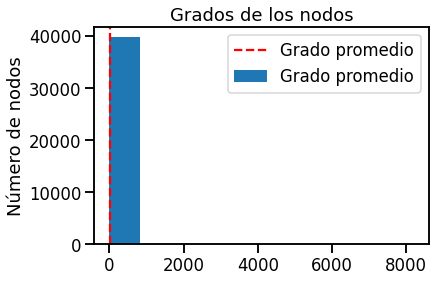

In [ ]:
plt.hist(degree_list,label='Grado promedio')
plt.axvline(av_degree,color='r',linestyle='dashed',label='Grado promedio')
plt.legend()
plt.ylabel('Número de nodos')
plt.title('Grados de los nodos')

Vemos que cada usuario es retuiteado en promedio 4 veces. Igualmente hay que considerar que hay algunos pocos (influencers, famosos, etc) que tienen un grado altísimo, mientras que la mayoría de la gente tiene muy pocos retweets (menos de 3). Esto lo mostraremos a continuación. 

### Distribución 

In [ ]:
users_nodes.describe

<bound method NDFrame.describe of Empty DataFrame
Columns: []
Index: [2737379453, 2258074658, 159909978, 105301854, 290671142, 208721168, 706109159708729344, 742492143885930496, 473194490, 155395122, 252168075, 1238117630696972289, 37232479, 1279224657124753408, 1299172647583051777, 920281298735976449, 145461175, 4824382060, 147385733, 1118888183343853569, 418899788, 3991086621, 881308200095678466, 1537340682, 2811705634, 2744470601, 1544714364, 885963124754567168, 148461640, 177648210, 606632391, 2520619430, 849688115967078400, 1174097745948422145, 2232463863, 853780872268582918, 1038901266, 158218244, 2229256457, 307409107, 114477009, 148839779, 327180205, 833159505332563968, 156054222, 158578695, 2840280909, 967145407, 1110543608703303682, 2699291461, 1348389929143906305, 1014581050289410048, 2923041125, 3416293883, 174754723, 1285055382210125832, 334233849, 1003015970213040133, 149643369, 1252422390946115584, 2915779377, 1928320513, 846698894742474754, 1192415849400938496, 94794650

In [ ]:
print(degree)

[('2737379453', 9), ('2258074658', 19), ('159909978', 1), ('105301854', 10), ('290671142', 15), ('208721168', 1), ('706109159708729344', 8), ('742492143885930496', 7), ('473194490', 22), ('155395122', 16), ('252168075', 8207), ('1238117630696972289', 3), ('37232479', 4), ('1279224657124753408', 5), ('1299172647583051777', 1), ('920281298735976449', 11), ('145461175', 1), ('4824382060', 4), ('147385733', 1), ('1118888183343853569', 1), ('418899788', 1), ('3991086621', 2), ('881308200095678466', 10), ('1537340682', 1), ('2811705634', 4), ('2744470601', 1), ('1544714364', 1), ('885963124754567168', 1), ('148461640', 1), ('177648210', 13), ('606632391', 6), ('2520619430', 1), ('849688115967078400', 1), ('1174097745948422145', 2), ('2232463863', 1), ('853780872268582918', 2), ('1038901266', 3), ('158218244', 1), ('2229256457', 3), ('307409107', 1), ('114477009', 3), ('148839779', 4), ('327180205', 1), ('833159505332563968', 7), ('156054222', 16), ('158578695', 1), ('2840280909', 1), ('96714

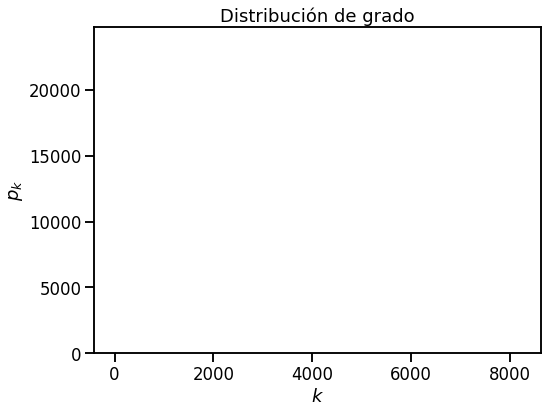

In [ ]:
deg_seq = np.array([k for v, k in degree])
users_nodes['degree'] = deg_seq

deg_histo = nx.degree_histogram(G)
bins = range(len(deg_histo))

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title('Distribución de grado')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$p_k$')
ax.bar(bins, deg_histo)
plt.show()

Entendemos que no se ve nada en este gráfico porque hay mucha diferencia de grados entre los distintos nodos. Sobre todo, sabiendo que el grado medio es 4, y en el describe se ve incluso que la mayoría rondan ese valor, salvo algunos outliers, llegando a un máximo de grado 8207.

En la siguiente tabla se listan a los 10 usuarios con mayor cantidad de retweets.

In [ ]:
users_nodes.sort_values("degree", ascending = False).head(10)

,degree
252168075,8207
130979339,5553
73102744,5362
367933714,3849
593189095,3834
2687724840,3175
931564592328781824,3136
144929758,2657
312708081,1630
1077176953,589


### Coeficiente de clustering de Watts-Strogatz

In [ ]:
clustering_coefficient = nx.clustering(G)
users_nodes['Cws'] = list(clustering_coefficient.values())

In [ ]:
users_nodes.head()

,degree,Cws
2737379453,9,0.000000
2258074658,19,0.052632
159909978,1,0.000000
105301854,10,0.066667
290671142,15,0.066667


### Densidad

In [ ]:
density = nx.density(G)

print('La densidad de vertices es: ' + str(density))

La densidad de vertices es: 0.00011793432854364539


### Asortatividad

In [ ]:
assortativity = nx.degree_assortativity_coefficient(G)

print('La asortatividad del grafo es: ' + str(assortativity))

La asortatividad del grafo es: -0.2213190254294167


### Transitividad

In [ ]:
print('La transitividad del grafo es:', nx.transitivity(G))

La transitividad del grafo es: 0.0016125612488585316


# **2. Centralidad**

Calcular 5 métricas de centralidad de nodos. Graficar la distribución de cada una de ellas ¿Existe alguna correlación entre las distintas centralidades? 

Hacer un ranking con los 10 nodos más centrales para cada métrica. ¿Hay coincidencia entre los rankings?. ¿Qué características tienen los usuarios más centrales y sus respectivos tweets?

**Opcional:** Determinar si existe alguna correlación entre la centralidad de un nodo y su actividad en red social. Es decir, evaluar si los usuarios que más escriben son los más centrales o no.

In [ ]:
!pip install igraph #para este punto usamos igraph porque es mas rapido que networkX

In [ ]:
print(igraph.__version__) #version

0.9.8


In [ ]:

G_igraph = Graph.from_networkx(G)

In [ ]:
G_igraph

### Medidas de Centralidad

In [ ]:
betweenness = Graph.betweenness(G_igraph)
closeness = Graph.closeness(G_igraph)
eigenvector = Graph.eigenvector_centrality(G_igraph)
page_rank = Graph.pagerank(G_igraph)


In [ ]:
harm_central = Graph.harmonic_centrality(G_igraph)
strength = Graph.strength(G_igraph)

Creamos el dataset a partir de las medidas de centralidad

In [ ]:
users_nodes['betweenness'] = list(betweenness)
users_nodes['eigenvector'] = list(eigenvector)
users_nodes['closeness'] = list(closeness)
users_nodes['page_rank'] = list(page_rank)
users_nodes['harm_central'] = list(harm_central)
users_nodes['strength'] = list(strength)
users_nodes.head()

,degree,Cws,betweenness,eigenvector,closeness,page_rank,harm_central,strength
2737379453,9,0.000000,78111.640852,0.000748,0.244898,0.000038,0.250772,9.0
2258074658,19,0.052632,130535.561685,0.009091,0.286305,0.000070,0.307703,19.0
159909978,1,0.000000,0.000000,0.000007,0.196722,0.000007,0.198210,1.0
105301854,10,0.066667,31376.713412,0.010696,0.304398,0.000036,0.325685,10.0
290671142,15,0.066667,291383.100735,0.011937,0.308014,0.000056,0.329096,15.0


Guardamos el dataset ante posibles colapso de Google Colab

In [ ]:
users_nodes.to_csv('node_centrality.csv')

In [ ]:
from google.colab import files
files.download("node_centrality.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
users_nodes = pd.read_csv('node_centrality.csv', index_col = 0)

In [ ]:
users_nodes.shape

(39800, 8)

### ¿Existe alguna correlación entre las distintas centralidades? 

In [ ]:
users_nodes.corr()

,degree,Cws,betweenness,eigenvector,closeness,page_rank,harm_central,strength
degree,1.000000,-0.002094,0.982334,0.778950,0.027846,0.989795,0.074523,1.000000
Cws,-0.002094,1.000000,-0.006223,0.184881,0.057311,-0.003887,0.258270,-0.002094
betweenness,0.982334,-0.006223,1.000000,0.732586,0.021013,0.971665,0.054514,0.982334
eigenvector,0.778950,0.184881,0.732586,1.000000,0.111551,0.776635,0.417186,0.778950
closeness,0.027846,0.057311,0.021013,0.111551,1.000000,0.028761,-0.375328,0.027846
page_rank,0.989795,-0.003887,0.971665,0.776635,0.028761,1.000000,0.059555,0.989795
harm_central,0.074523,0.258270,0.054514,0.417186,-0.375328,0.059555,1.000000,0.074523
strength,1.000000,-0.002094,0.982334,0.778950,0.027846,0.989795,0.074523,1.000000


Visualizamos mediante un heatmap (mapa de calor):

<AxesSubplot:>

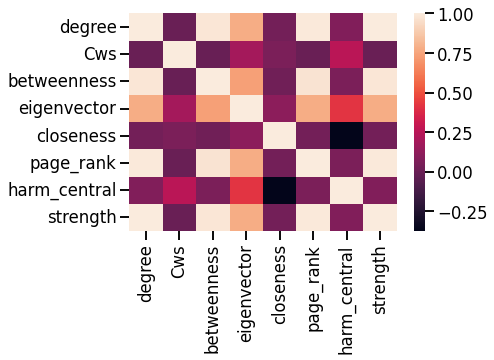

In [ ]:
import seaborn as sns
sns.heatmap(users_nodes.corr())

### Distribución de estas métricas mediante un histograma



In [ ]:
users_nodes.describe()

,degree,Cws,betweenness,eigenvector,closeness,page_rank,harm_central,strength
count,39800.000000,39800.000000,3.980000e+04,39800.000000,39743.000000,39800.000000,39800.000000,39800.000000
mean,4.693668,0.099906,5.310058e+04,0.006818,0.278359,0.000025,0.274840,4.693668
std,69.302786,0.242676,2.036286e+06,0.012027,0.086733,0.000391,0.053282,69.302786
min,1.000000,0.000000,0.000000e+00,0.000000,0.130407,0.000006,0.000000,1.000000
25%,1.000000,0.000000,0.000000e+00,0.000498,0.254959,0.000009,0.255486,1.000000
50%,1.000000,0.000000,0.000000e+00,0.005005,0.273192,0.000010,0.286548,1.000000
75%,3.000000,0.000000,2.133929e+03,0.009732,0.284754,0.000016,0.302770,3.000000
max,8207.000000,1.000000,2.703364e+08,1.000000,1.000000,0.040722,0.478310,8207.000000


In [ ]:
df2 = users_nodes[['eigenvector', 'closeness','page_rank', 'harm_central']]

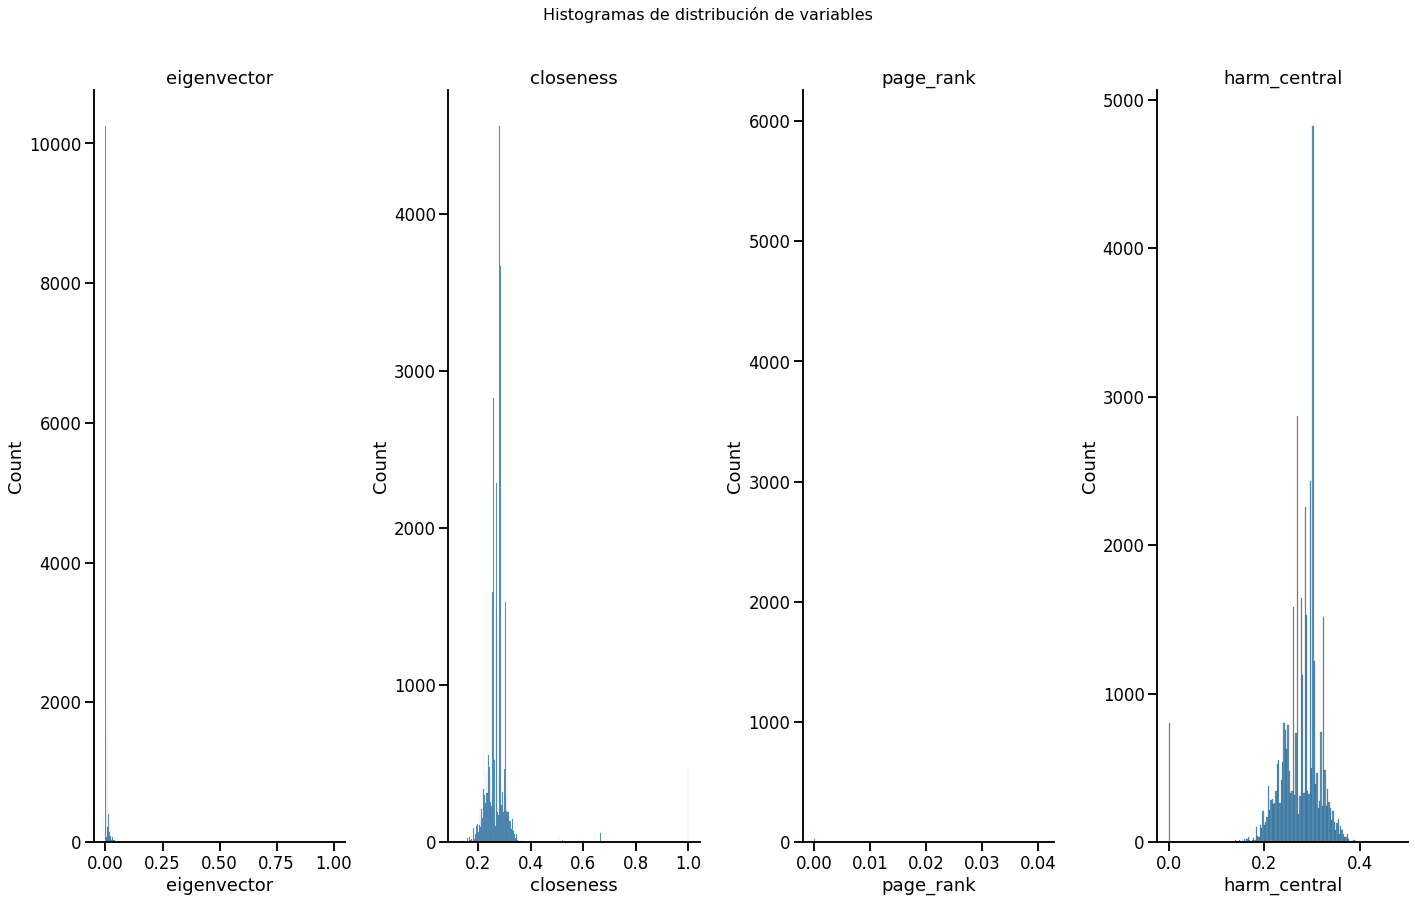

In [ ]:
fig, axes = plt.subplots(1,4,figsize=(20,12))
axes = axes.ravel()
for i, col in enumerate(df2.columns):
    axes[i].set_title(f'{col}')
    sns.histplot(ax=axes[i], x=df2[col],)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)

fig.suptitle('Histogramas de distribución de variables', fontsize=16, y=1.05)
fig.subplots_adjust(hspace=0.3)

fig.tight_layout();

## Ranking de los nodos más centrales

In [ ]:
def primeros_10(columna):
  print("Primeros 10 para", columna)
  return users_nodes.sort_values(columna, ascending=False)[columna].head(10)
  

In [ ]:
primeros_10('betweenness')

Primeros 10 para betweenness


252168075             2.703364e+08
130979339             1.785181e+08
73102744              1.259533e+08
593189095             1.139237e+08
931564592328781824    9.875625e+07
367933714             9.179453e+07
2687724840            7.542586e+07
144929758             7.064363e+07
312708081             2.702409e+07
593340893             1.804990e+07
Name: betweenness, dtype: float64

In [ ]:
primeros_10('eigenvector')

Primeros 10 para eigenvector


130979339             1.000000
73102744              0.972362
252168075             0.738339
367933714             0.715609
2687724840            0.500054
593189095             0.361535
312708081             0.341865
144929758             0.321722
931564592328781824    0.262567
959033548379508736    0.091112
Name: eigenvector, dtype: float64

In [ ]:
primeros_10('page_rank')

Primeros 10 para page_rank


252168075             0.040722
130979339             0.033187
73102744              0.030866
593189095             0.029142
367933714             0.021966
2687724840            0.019368
144929758             0.016507
931564592328781824    0.014996
312708081             0.008463
1077176953            0.003588
Name: page_rank, dtype: float64

In [ ]:
primeros_10('closeness')

Primeros 10 para closeness


2158099477             1.0
404411533              1.0
1157459919018299393    1.0
2919790036             1.0
333736029              1.0
1117084801666813954    1.0
4743144975             1.0
3010259950             1.0
550455502              1.0
2468526958             1.0
Name: closeness, dtype: float64

In [ ]:
primeros_10('harm_central')

Primeros 10 para harm_central


252168075              0.478310
130979339              0.457576
73102744               0.434693
367933714              0.431454
1116405885226688512    0.416170
931564592328781824     0.414999
950696136              0.414137
206371045              0.413807
1283193788744204296    0.411530
2687724840             0.408592
Name: harm_central, dtype: float64

In [ ]:
primeros_10('degree')

Primeros 10 para degree


252168075             8207
130979339             5553
73102744              5362
367933714             3849
593189095             3834
2687724840            3175
931564592328781824    3136
144929758             2657
312708081             1630
1077176953             589
Name: degree, dtype: int64

#### **Pequeña conclusión**

* Podemos observar que los nodos (usuarios) que tienen mayor grado en el grafo, son los que al calcular las métricas de centralidad (Betweenness, Closeness, Page Rank, Harmony centrality) en el mismo grafo tienen los valores más altos, respectivamente. 
* Esto nos da idea también de que existe un sesgo, ya que las personas que más retuits consiguen son las que dirigen más el flujo de la información dentro del grafo estudiado en este caso (posición a favor y en contra de las vacunas). 

# **3. Comunidades**

Utilizar el algoritmo de Louvain con el parámetro "resolución" igual a 1. Caracterizar las comunidades halladas (cantidad, distribución de tamaños). Utilizar la modularidad y otras dos métricas a elección para evaluar la calidad de la partición encontrada.

Variar el parámetro "resolución" y observar cómo cambia la distribución de comunidades encontradas. ¿Existe algún valor para el cual se identifiquen dos grandes comunidades?

Elegir otro algoritmo de detección de comunidades y comparar los resultados con los obtenidos anteriormente.

Opcional: Correr el algoritmo de Louvain con distintas semillas aleatorias. Utilizar alguna métrica de comparación externa entre las particiones obtenidas para determinar en qué medida depende el algoritmo de la condición inicial.

In [ ]:
partition = community.best_partition(G)
partition

{'2737379453': 0,
 '2258074658': 0,
 '159909978': 0,
 '105301854': 0,
 '290671142': 0,
 '208721168': 0,
 '706109159708729344': 0,
 '742492143885930496': 0,
 '473194490': 0,
 '155395122': 0,
 '252168075': 1,
 '1238117630696972289': 1,
 '37232479': 0,
 '1279224657124753408': 1,
 '1299172647583051777': 1,
 '920281298735976449': 0,
 '145461175': 1,
 '4824382060': 0,
 '147385733': 1,
 '1118888183343853569': 1,
 '418899788': 1,
 '3991086621': 1,
 '881308200095678466': 0,
 '1537340682': 1,
 '2811705634': 0,
 '2744470601': 1,
 '1544714364': 1,
 '885963124754567168': 1,
 '148461640': 1,
 '177648210': 1,
 '606632391': 0,
 '2520619430': 1,
 '849688115967078400': 1,
 '1174097745948422145': 0,
 '2232463863': 1,
 '853780872268582918': 0,
 '1038901266': 2,
 '158218244': 1,
 '2229256457': 0,
 '307409107': 1,
 '114477009': 62,
 '148839779': 0,
 '327180205': 1,
 '833159505332563968': 0,
 '156054222': 0,
 '158578695': 1,
 '2840280909': 1,
 '967145407': 0,
 '1110543608703303682': 1,
 '2699291461': 0,
 '13

In [ ]:
max(partition.values())

356

# 3. Comunidades

## 3.1. Louvain

In [ ]:
coms = algorithms.louvain(G, resolution=1., randomize=False)
print(coms)

In [ ]:
len(coms.communities)

368

In [ ]:
for i in coms.communities:
    print(len(i))

7354
7229
6748
6411
3494
3218
2199
604
231
228
213
205
174
106
87
85
48
47
46
45
44
32
27
27
22
20
16
15
15
13
12
12
11
10
9
9
8
8
8
8
8
7
7
7
7
6
6
5
5
5
5
5
4
4
4
4
4
4
4
4
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


Vemos que por Louvain, con resolución igual a 1, obtenemos 368 comunidades distintas, de las cuales hay 4 grandes distribuidas casi equitativamente; le siguen 3 comunidades con la mitad del valor y luego baja quedando muchas comunidades con muy pocos usuarios. 

### Evaluación interna de Louvain

#### Densidad interna

In [ ]:
print('Densidad interna con Louvain:', evaluation.internal_edge_density(G, coms))

Densidad interna con Louvain: FitnessResult(min=0, max=3.0, score=0.7081117318610662, std=0.47309710670990746)


#### Modularidad

In [ ]:
print('Modularidad con Louvain:', evaluation.newman_girvan_modularity(G, coms))

Modularidad con Louvain: FitnessResult(min=None, max=None, score=0.5754314902268667, std=None)


#### Índice de corte

In [ ]:
print('Índice de corte con Louvain:', evaluation.cut_ratio(G, coms))

Índice de corte con Louvain: FitnessResult(min=0.0, max=4.08373542420587e-05, score=2.433048540016517e-06, std=7.331538441877589e-06)


In [ ]:
# plt.bar(partition.values(), 100000)

## 3.2. Variando la resolución

In [ ]:
resolutions = [0.1, 1, 10]
comms_dict = {}
for resolution in resolutions:
    comms = algorithms.louvain(G, resolution=resolution, randomize=False)
    comms_dict[resolution] = comms 
    print('### Para una resolución de', resolution, ":")
    print("- La cantidad de comunidades es", len(comms.communities))
    print("- La densidad interna da", evaluation.internal_edge_density(G, comms))
    print('- La modularidad da:', evaluation.newman_girvan_modularity(G, comms))
    print('- El índice de corte da:', evaluation.cut_ratio(G, comms))
    print("- Tamaño de las primeras 5 comunidades:")
    for i in comms.communities[:5]:
        print(len(i))
    print("\n")

### Para una resolución de 0.1 :
- La cantidad de comunidades es 798
- La densidad interna da FitnessResult(min=0, max=2.0, score=0.4450929710051591, std=0.48314124201147596)
- La modularidad da: FitnessResult(min=None, max=None, score=0.4387844089762763, std=None)
- El índice de corte da: FitnessResult(min=0.0, max=0.0003295570465941581, score=4.727112568785974e-05, std=5.506926612206526e-05)
- Tamaño de las primeras 5 comunidades:
3018
2696
2223
2113
1813


### Para una resolución de 1 :
- La cantidad de comunidades es 368
- La densidad interna da FitnessResult(min=0, max=3.0, score=0.7081117318610662, std=0.47309710670990746)
- La modularidad da: FitnessResult(min=None, max=None, score=0.5754314902268667, std=None)
- El índice de corte da: FitnessResult(min=0.0, max=4.08373542420587e-05, score=2.433048540016517e-06, std=7.331538441877589e-06)
- Tamaño de las primeras 5 comunidades:
7354
7229
6748
6411
3494


### Para una resolución de 10 :
- La cantidad de comunidades es 319
- La de

### Prueba de resolución mayor a 10

In [ ]:
comss = algorithms.louvain(G, resolution=100, randomize=False)
print(comss)

In [ ]:
len(comss.communities)

315

In [ ]:
for i in comss.communities[:5]:
    print(len(i))

38998
106
32
22
13


### Conclusión

Con `resolución` igual a `10` se identifican **dos** grandes comunidades: una de *22858* usuarios y la otra de *15834*. Luego, el resto de los usuarios quedan distribuidos en comunidades mucho más pequeñas.

Probamos también Louvain con resoluciones más altas (100, 100000, etc) y vimos que en todos los casos llega a un tope de 315 comunidades, en donde se ve que hay una que concentra a la mayoría de los usuarios (38998) y todos los demás quedan en comunidades pequeñas.


## 3.3. Label propagation

In [ ]:
comms = algorithms.label_propagation(G)

In [ ]:
comms.method_name

'Label Propagation'

In [ ]:
comms.method_parameters

{'': ''}

In [ ]:
comms.communities

[['143546521',
  '211147640',
  '154309333',
  '1431760152',
  '147249049',
  '3060306598',
  '739883637290770432',
  '2546904036',
  '517826994',
  '900830372472254466',
  '616317072',
  '3991226542',
  '195564245',
  '2505849128',
  '1662756524',
  '3416752941',
  '1626766404',
  '3775269923',
  '1210335035108278274',
  '1315683971884343300',
  '2557943891',
  '614797224',
  '2382207576',
  '1173437389722836993',
  '2700240205',
  '720403739480354817',
  '524884357',
  '848375175972347906',
  '1219462126781288453',
  '1245014089627308036',
  '180599582',
  '695608174389391361',
  '828820114552262656',
  '2949375299',
  '3404769603',
  '301786491',
  '208599982',
  '587498428',
  '1321242036029325312',
  '4459950279',
  '157704165',
  '1312618476306038785',
  '4714630516',
  '2798890552',
  '2985875476',
  '1128635880',
  '1203813886627139585',
  '174416954',
  '1070867357596291072',
  '160075279',
  '545052628',
  '145001496',
  '18705997',
  '4840083875',
  '727666699',
  '849052350

In [ ]:
len(comms.communities)

1039

In [ ]:
for i in comms.communities:
    print(len(i))

14855
11994
2727
2715
1611
1438
308
86
61
59
59
49
46
46
44
42
41
41
38
38
34
34
34
32
32
32
30
29
29
28
27
26
26
25
25
25
23
23
22
21
20
20
20
20
20
19
19
18
18
17
17
15
15
15
14
14
13
13
13
13
13
13
13
12
12
12
12
12
11
11
11
11
11
10
10
10
10
10
10
10
9
9
9
9
9
9
9
9
9
9
9
8
8
8
8
8
8
8
8
8
7
7
7
7
7
7
7
7
7
7
7
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2

Si bien con Label propagation obtuvimos muchas más comunidades (1039 vs las 368 de Louvain), vemos que hay dos grupos enormes de usuarios (rondando los 13000 cada uno), mientras que todo el resto de la gente queda distribuida en las demás comunidades mucho más pequeñas. 

### Evaluación interna de Label propagation

#### Densidad interna

In [ ]:
m = G.number_of_edges()
N = G.number_of_nodes()
print('Densidad del grafo:', m/(N*(N-1)/2))
print('Densidad interna de Label propagation:', evaluation.internal_edge_density(G, comms))

Densidad del grafo: 0.00011793432854364539
Densidad interna de Label propagation: FitnessResult(min=0, max=2.0, score=0.7645412293772558, std=0.439916726950157)


#### Modularidad

In [ ]:
print('Modularidad de Label propagation:', evaluation.newman_girvan_modularity(G, comms))

Modularidad de Label propagation: FitnessResult(min=None, max=None, score=0.4994214924606615, std=None)


#### Índice de corte

In [ ]:
print('Índice de corte de Label propagation:', evaluation.cut_ratio(G, comms))

Índice de corte de Label propagation: FitnessResult(min=0.0, max=2.796795990513268e-06, score=3.387555161513647e-08, std=2.783886233066043e-07)


### Conclusión

* En este primer notebook vimos cómo armar un grafo dirigido, luego vimos su versión no dirigida para calcular sus métricas correspondientes. 

* También calculamos métricas de centralidad correspondientes con igraph ya que con networkx tuvimos problemas de cómputo en cuanto al tiempo empleado. 


* Podemos observar que los nodos (usuarios) que tienen mayor grado en el grafo, son los que al calcular las métricas de centralidad (Betweenness, Closeness, Page Rank, Harmony centrality) en el mismo grafo tienen los valores más altos, respectivamente.


* Esto nos da idea también de que existe un sesgo, ya que las personas que más retuits consiguen son las que dirigen más el flujo de la información dentro del grafo estudiado en este caso (posición a favor y en contra de las vacunas).

* En la parte de comunidades, las calculamos con Louvain y con Label Propagation. Los resultados difieren entre sí, en cuanto al número de comunidades detectadas. 




